In [24]:
from IPython.display import display, HTML
import sympy as sp
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [2]:
def _choose_points(func, bounds):
    left, right = bounds
    points = list(np.linspace(left, right, 1000))
    for i in range(100):
        sample = sorted(list(random.sample(points, 3)))
        x1, x2, x3 = sample
        if (x1 < x2 < x3) & (func(x1) > func(x2) < func(x3)):
            return x1, x2, x3
        

def _find_center(func, x1, x2, x3):
    if (x1, func(x1)) == (x2, func(x2)) or (x2, func(x2)) == (x3, func(x3)) or (x1, func(x1)) == (x3, func(x3)):
        return
    f_1, f_2, f_3 = func(x1), func(x2), func(x3)
    a1 = (f_2 - f_1) / (x2 - x1)
    a2 = 1/(x3 - x2)*((f_3 - f_1)/(x3 - x1) - (f_2 - f_1)/(x2 - x1))
    center = 0.5*(x1 + x2 - a1/a2)
    return center

def _show_convergency(data):
    print(data)
    plt.figure()
    plt.plot(list(range(len(data))), data)
    plt.xlabel('iter num')
    plt.ylabel('interval size')
    plt.title('convergency estimation')
    plt.show()

In [9]:
def golden_ratio(func, bounds, accuracy=10**-5, max_iter=500, show_interim_results=False, show_convergency=False, return_data=False):
    func = sp.sympify(func)
    arg = list(func.free_symbols)[0]
    func = sp.lambdify(arg, func)
    iter_num = 0
    
    left, right = bounds
    ratio = (np.sqrt(5) - 1) / 2
    
    interim_results = pd.DataFrame(columns=['N', 'a', 'b', 'x', 'y', 'f(x)', 'f(y)'])
    
    while abs(right - left) > accuracy:
        if iter_num >= max_iter:
            break
            
        x = right - ratio*(right - left)
        y = left + ratio*(right - left)
        
        row = {
            'N': iter_num,
            'a': left,
            'b': right,
            'x': x,
            'y': y,
            'f(x)': func(x),
            'f(y)': func(y)
        }
        interim_results = interim_results.append(row, ignore_index=True)

        if func(x) < func(y):
            right = y
        else:
            left = x
        
        iter_num += 1
    
    flag = 1 if iter_num >= max_iter else 0
    x_min = (left + right) / 2
    f_min = func(x_min)
    
    interim_results.set_index('N', inplace=True)
    if show_interim_results:
        display(HTML(interim_results.to_html()))
    if show_convergency:
        interval_sizes = list(interim_results['b'] - interim_results['a'])
        _show_convergency(interval_sizes)
    result = {'arg': x_min, 'func': f_min, 'flag': flag}
    if return_data:
        result['data'] = interim_results
    return result

In [10]:
def parabola_method(func, bounds, accuracy=10**-5, max_iter=500, show_interim_results=False, show_convergency=False, return_data=False):
    func = sp.sympify(func)
    arg = list(func.free_symbols)[0]
    func = sp.lambdify(arg, func)
    iter_num = 0
    
    left, right = bounds
    x1, x2, x3 = left, (left + right) / 2, right
    prev_min = (left + right) / 2
    curr_min = _find_center(func, x1, x2, x3)
    interim_results = pd.DataFrame(columns=['N', 'x1', 'x2', 'x3', 'u', 'f(u)'])
    
    while abs(curr_min - prev_min) > accuracy:
        if iter_num >= max_iter:
            break
            
        c = min(x2, curr_min)
        d = max(x2, curr_min)
        
        row = {
            'N': iter_num,
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'u': curr_min,
            'f(u)': func(curr_min)
        }
        interim_results = interim_results.append(row, ignore_index=True)
        
        if func(c) < func(d):
            x1, x2, x3 = x1, c, d
        else:
            x1, x2, x3 = c, d, right
            
        prev_min = curr_min
        curr_min = _find_center(func, x1, x2, x3)
            
        iter_num += 1

    flag = 1 if iter_num >= max_iter else 0
    interim_results.set_index('N', inplace=True)
    if show_interim_results:
        display(HTML(interim_results.to_html()))
    if show_convergency:
        interval_sizes = list(interim_results['x3'] - interim_results['x1'])
        _show_convergency(interval_sizes)
    result = {'arg': curr_min, 'func': func(curr_min), 'flag': flag}
    if return_data:
        result['data'] = interim_results
    return result

In [11]:
def combined_brent(func, bounds, accuracy=10**-5, max_iter=500, show_interim_results=False, show_convergency=False, return_data=False):
    func = sp.sympify(func)
    arg = list(func.free_symbols)[0]
    func = sp.lambdify(arg, func)
    iter_num = 0
    ratio = (3 - np.sqrt(5)) / 2
    
    left, right = bounds
    x_min = w = v = left + ratio*(right - left)
    d_curr = d_prev = right - left
    
    interim_results = pd.DataFrame(columns=['a', 'b', 'x', 'w', 'v', 'u'])
    
    while max(x_min - left, right - x_min) > accuracy:
        if iter_num >= max_iter:
            break
            
        g = d_prev / 2
        d_prev = d_curr
        u = _find_center(func, x_min, w, v)
        if not u or (u < left or u > right) or abs(u - x_min) > g:
            if x_min < (left + right) / 2:
                u = x_min + ratio*(right - x_min)
                d_prev = right - x_min
            else:
                u = x_min - ratio*(x_min - left)
                d_prev = (x_min - left)
        d_curr = abs(u - x_min)
        
        row = {
            'N': iter_num,
            'a': left,
            'b': right,
            'x': x_min,
            'w': w,
            'v': v,
            'u': u
        }
        interim_results = interim_results.append(row, ignore_index=True)
        
        if func(u) > func(x_min):
            if u < x_min:
                left = u
            else:
                right = u
            if func(u) <= func(w) or w == x_min:
                v = w
                w = u
            else:
                if func(u) <= func(v) or v == x_min or v == w:
                    v = u
        else:
            if u < x_min:
                right = x_min
            else:
                left = x_min
            v = w
            w = x_min
            x_min = u
            
        iter_num += 1
        
    flag = 1 if iter_num >= max_iter else 0
    interim_results.set_index('N', inplace=True)
    if show_interim_results:
        display(HTML(interim_results.to_html()))
    if show_convergency:
        interval_sizes = list(interim_results['b'] - interim_results['a'])
        _show_convergency(interval_sizes)
    result = {'arg': x_min, 'func': func(x_min), 'flag': flag}
    if return_data:
        result['data'] = interim_results
    return result

In [29]:
def solve(compare=False):
    func = input('Введите функцию в аналитическом виде: ')
    bounds = input('Введите ограничения по аргументу: ')
    bounds = tuple(map(float, map(sp.sympify, bounds.split())))
    accuracy = input('Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): ')
    accuracy = 10e-5 if not accuracy else float(accuracy)
    max_iter = input('Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): ')
    max_iter = 500 if not max_iter else int(accuracy)
    if compare:
        values = [['Полученное решение', 'Время выполнения (ms)', 'Количество итераций']]
        for algorithm in (golden_ratio, parabola_method, combined_brent):
            start = time.time()
            result = algorithm(
                func, bounds, accuracy=accuracy, max_iter=max_iter,
                return_data=True
            )
            solution = result['arg']
            end = time.time()
            duration = end - start
            iter_num = len(result['data'].index)
            values.append([solution, duration, iter_num])
        fig = go.Figure(data=[go.Table(header=dict(values=['Параметр', 'метод золотого сечения', 'метод парабол', 'комбинированный метод Брента']),
                 cells=dict(values=values))])
        fig.show()
        return
        
    else:
        method = int(input(
        """
        Выберите метод решения:
        1 - метод золотого сечения
        2 - метод парабол
        3 - комбинированный метод Брента
        Метод: 
        """
        ))
        show_interim_results = bool(int(input('Показать промежуточные результаты? 1-да / 0-нет: ')))
        show_convergency = bool(int(input('Показать график сходимости? 1-да / 0-нет: ')))
        if method == 1:
            return golden_ratio(
                func, bounds, accuracy=accuracy, max_iter=max_iter,
                show_interim_results=show_interim_results, show_convergency=show_convergency
            )
        elif method == 2:
            return parabola_method(
                func, bounds, accuracy=accuracy, max_iter=max_iter,
                show_interim_results=show_interim_results, show_convergency=show_convergency
            )
        elif method == 3:
            return combined_brent(
                func, bounds, accuracy=accuracy, max_iter=max_iter,
                show_interim_results=show_interim_results, show_convergency=show_convergency
            )

## Тесты

Введите функцию в аналитическом виде: -5*x^5 + 4*x^4 - 12*x^3 + 11*x^2 - 2*x + 1
Введите ограничения по аргументу: -0.5 0.5
Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): 
Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): 

        Выберите метод решения:
        1 - метод золотого сечения
        2 - метод парабол
        3 - комбинированный метод Брента
        Метод: 
        3
Показать промежуточные результаты? 1-да / 0-нет: 1
Показать график сходимости? 1-да / 0-нет: 1


,a,b,x,w,v,u
N,,,,,,
0.0,-0.500000,0.500000,-0.118034,-0.118034,-0.118034,0.118034
1.0,-0.118034,0.500000,0.118034,-0.118034,-0.118034,0.263932
2.0,-0.118034,0.263932,0.118034,0.263932,-0.118034,0.134553
3.0,-0.118034,0.134553,0.118034,0.134553,0.263932,0.104468
4.0,-0.118034,0.118034,0.104468,0.118034,0.134553,0.109841
5.0,0.104468,0.118034,0.109841,0.104468,0.118034,0.109893
6.0,0.104468,0.109893,0.109841,0.109893,0.104468,0.109860


[1.0, 0.6180339887498949, 0.38196601125010515, 0.2525871396635135, 0.2360679774997897, 0.013565789502939601, 0.0054247631784741235]


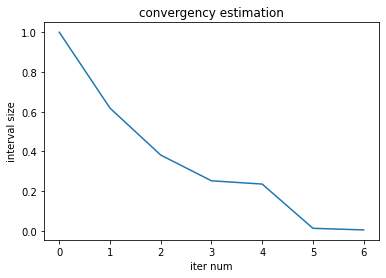

{'arg': 0.10985997156890047, 'func': 0.89763297189619, 'flag': 0}

In [31]:
solve()

In [33]:
solve(compare=True)

Введите функцию в аналитическом виде: (log(x-2))^2 + log((10-x))^2 - x^0.2
Введите ограничения по аргументу: 6 9.9
Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): 
Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): 


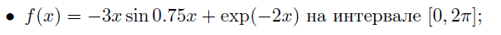

In [34]:
solve()

Введите функцию в аналитическом виде: -3*x*sin(0.75*x) + exp(-2*x)
Введите ограничения по аргументу: 0 2*pi
Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): 
Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): 

        Выберите метод решения:
        1 - метод золотого сечения
        2 - метод парабол
        3 - комбинированный метод Брента
        Метод: 
        1
Показать промежуточные результаты? 1-да / 0-нет: 0
Показать график сходимости? 1-да / 0-нет: 0


{'arg': 2.706468761882862, 'func': -7.2743579699319145, 'flag': 0}

In [35]:
solve()

Введите функцию в аналитическом виде: exp(3*x) + 5*exp(-2*x)
Введите ограничения по аргументу: 0 1
Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): 
Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): 

        Выберите метод решения:
        1 - метод золотого сечения
        2 - метод парабол
        3 - комбинированный метод Брента
        Метод: 
        2
Показать промежуточные результаты? 1-да / 0-нет: 0
Показать график сходимости? 1-да / 0-нет: 0


{'arg': 0.24066474554275802, 'func': 5.148340681663614, 'flag': 0}

In [36]:
solve()

Введите функцию в аналитическом виде: 0.2*x*log(x) + (x-2.3)^2
Введите ограничения по аргументу: 0.5 2.5
Введите точность алгоритма (оставьте пустым для значения по умолчанию=10e-5): 
Введите макс. кол-во итераций (оставьте пустым для значения по умолчанию=500): 

        Выберите метод решения:
        1 - метод золотого сечения
        2 - метод парабол
        3 - комбинированный метод Брента
        Метод: 
        1
Показать промежуточные результаты? 1-да / 0-нет: 0
Показать график сходимости? 1-да / 0-нет: 0


{'arg': 2.124647831409276, 'func': 0.35097788020729825, 'flag': 0}